The arrival process is modelled as a Poisson process. Report the
fraction of blocked customers, and a confidence interval for this
fraction. Choose the service time distribution as exponential.
Parameters: m = 10, mean service time = 8 time units, mean
time between customers = 1 time unit (corresponding to an
offered traffic of 8 Erlang), 10 x 10.000 customers.
This system is sufficiently simple such that the analytical
solution is known. See the last slide for the solution. Verify your
simulation program using this knowledge.

First, implement a simulation class which holds all functionality needed for this excercise:

In [49]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Jun  6 13:33:44 2023

@author: max
"""

import numpy as np
import matplotlib.pyplot as plt 
import scipy.stats as st

class customerSimulation:
    def __init__(self,n_customers,mean_arrival_time,n_cashiers,mean_service_time,n_experiments,arrivalmode=None,servicemode=None):
        self.n_c = n_customers
        self.cashier_capacity = n_cashiers
        self.cashiers_occupied = 0
        self.clock = 0 #arbitrary time-unit
        self.n_e = n_experiments
        self.n_rejected = 0
        self.CASHIERS_FREE = True
        self.cashier_time = []
        self.total_customers = n_experiments*n_customers
        self.arrivalTimes = self.initialize_arrivals(mean_arrival_time,arrivalmode)
        self.departureTimes = self.initialize_departures(mean_service_time,servicemode)
        self.rejected_results = [] #holds number rejected for experiments 
        self.clockResults = []
        self.meanArrivalTime = mean_arrival_time
        self.meanServiceTime = mean_service_time
        self.arrivalMode = arrivalmode
        self.serviceMode = servicemode
        
        
    def initialize_arrivals(self,mat,arrivalmode=None):
        if(arrivalmode==None):
            X = np.random.poisson(lam=mat,size=self.n_c).tolist()
            return X
        elif(arrivalmode=="erlang"):
            mean = 1
            shape_k = 1
            X = np.random.gamma(shape=shape_k,scale=mean,size=self.n_c).tolist()
            return X
        elif(arrivalmode=="hyperexponential"):
            p = 0.8
            lambda1 = 0.833333
            lambda2 = 5.0
            X = np.zeros(self.n_c)
            P = np.random.uniform(0,1,size=self.n_c)
            X[P <= p] = -np.log(1-np.random.uniform(0,1,size=(P <= p).sum()))/lambda1;
            X[P > p]  = -np.log(1-np.random.uniform(0,1,size=(P >  p).sum()))/lambda2;
            return X.tolist()
        
    
    def initialize_departures(self,mst,servicemode=None):
        if(servicemode==None):
            return np.random.exponential(scale=mst,size=self.n_c).tolist()
        elif(servicemode=="constant"):
            return [mst for x in range(self.n_c)]
        elif(servicemode=="pareto1"):
            k = 1.05
            return st.pareto.rvs(k,scale=mst*(k-1)/k,size=self.n_c).tolist()
        elif(servicemode=="pareto2"):
            k = 2.05
            return st.pareto.rvs(k,scale=mst*(k-1)/k,size=self.n_c).tolist()
        elif(servicemode=="uniform"):
            return (2*mst*np.random.uniform(size=self.n_c)).tolist()  
        
    
    def reinitialize(self):
        self.clock = 0
        self.n_rejected = 0
        self.cashier_time = []
        self.arrivalTimes = self.initialize_arrivals(self.meanArrivalTime,self.arrivalMode)
        self.departureTimes = self.initialize_departures(self.meanServiceTime,self.serviceMode)
        return None
    
    def get_next_event(self):
        ###Extracts arrival time and departure-time and removes entries from event-lists
        at = self.arrivalTimes[0]
        dt = self.departureTimes[0]
        self.arrivalTimes.pop(0)
        self.departureTimes.pop(0)
        return at,dt
    
    def assign_to_cashier(self,arrivalt,departuret):
        self.cashier_time = [x-arrivalt for x in self.cashier_time] #update passed time
        self.cashier_time = [x for x in self.cashier_time if x>0] #remove from cashier if service has been finished
        if(len(self.cashier_time)==self.cashier_capacity): #all cashiers are busy - reject customer 
            self.n_rejected += 1 
        else:
            self.cashier_time.append(departuret)
        return None
            
    def runSim(self):
        while(len(self.arrivalTimes)>0):
            at,dt = self.get_next_event()
            old_clock = self.clock
            self.clock += at
            self.assign_to_cashier(at,dt)
            #update cashier time 
        self.rejected_results.append(self.n_rejected)
        self.clockResults.append(self.clock)
        return None
    
    def runSimMultiple(self,n_experiments):
        self.runSim() #already initialized
        for i in range(n_experiments-1):
            self.reinitialize()
            self.runSim()
        return None
    
    def printResults(self):
        print(f"Number of rejected customers: {self.rejected_results}")
        print(f"Clock time for finished service: {self.clockResults}")
        return None
    
    def getRejectedResults(self):
        return self.rejected_results
    
    def getClockResults(self):
        return self.clockResults
            
    def getTheoreticalRejectedResult(self):
        A = self.meanArrivalTime*self.meanServiceTime
        numerator = (A**self.cashier_capacity)/np.math.factorial(self.cashier_capacity)
        denominator = sum([(A**i)/np.math.factorial(i) for i in range(self.cashier_capacity+1)])
        return numerator/denominator
        
    def extractStatistic(self,descriptor,alpha):
        if(descriptor=="clock"):
            theta = self.clockResults
        elif(descriptor=="rejections"):
            theta = self.rejected_results
        
        #estimate mean on per-experiment basis 
        theta_mean = [x/self.n_c for x in theta] #get per-experiment fraction
        #print(theta_mean)
        #estimate fraction across number of experiments 
        theta_exp_mean = sum(theta_mean)/self.n_e
        #print(theta_exp_mean)
        squared_diff = [x**2 - theta_exp_mean**2 for x in theta_mean]
        #print(squared_diff)
        var = 1/(self.n_e-1)*sum(squared_diff)
        #print(var)
        ci_val = (np.sqrt(var)/np.sqrt(self.n_e))*st.t.interval(confidence=0.95,df=self.n_e-1)[1] #positive entry
        CIL = [theta_exp_mean - ci_val, theta_exp_mean + ci_val]
        width = CIL[1]-CIL[0]
        return theta_exp_mean,var,CIL,width
    
    def printStatisticResults(self):
        if(self.arrivalMode!=None):
            title = self.arrivalMode
        elif(self.serviceMode!=None):
            title = self.serviceMode
        else:
            title = "Poisson arrival / exponential service"
        thetaMeasured, varianceMeasured, confint, cwidth = self.extractStatistic("rejections",0.95)
        print(f"{title} results")
        print(f"Estimated fraction of blocked customers: {thetaMeasured}")
        print(f"Estimated variance of estimate: {varianceMeasured}")
        print(f"95% Confidence-Interval (low,high): {confint}")
        print(f"Width of CI: {cwidth}")

        return None

Initialize experimental parameters

In [34]:
#general params
n_c = 10000
n_e = 10
m_serv = 10 #number of service units 
mean_arrival_time = 1
mean_service_time = 8



Mean absolute error: 0.007772835747048503


(array([ 3.,  5.,  6., 19., 19., 19., 14.,  9.,  4.,  2.]),
 array([0.00298894, 0.00396594, 0.00494294, 0.00591994, 0.00689694,
        0.00787394, 0.00885094, 0.00982794, 0.01080494, 0.01178194,
        0.01275894]),
 <BarContainer object of 10 artists>)

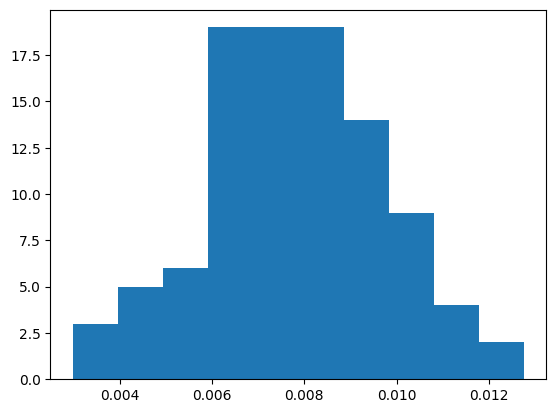

In [50]:
#setup exc 4.1, and run 100 times to ensure that errors are small
errors = []
errors_abs = []
for i in range(100):
    SIM = customerSimulation(n_c,mean_arrival_time,m_serv,mean_service_time,n_e)
    SIM.runSimMultiple(n_experiments=n_e)
    n_rejected = SIM.getRejectedResults()
    theoreticalB = SIM.getTheoreticalRejectedResult()
    thetaSTANDARD, varSTANDARD, confintSTANDARD, cwidthSTANDARD = SIM.extractStatistic("rejections",0.95)
    errors.append(thetaSTANDARD-theoreticalB)
    errors_abs.append(abs(thetaSTANDARD-theoreticalB))
#get the mean absolute error
print(f"Mean absolute error: {np.mean(errors_abs)}")

#make histogram of errors 
plt.figure()
plt.hist(errors)

We notice that the simulation systematically overestimates the theoretical fraction, but the errors are in general very small (0.7%)

<h1>4.2</h1>
The arrival process is modelled as a renewal process using the
same parameters as in Part 1 when possible. Report the
fraction of blocked customers, and a confidence interval for this
fraction for at least the following two cases

1. Experiment with Erlang distributed inter arrival times The Erlang distribution should have a mean of 1
2. hyper exponential inter arrival times. The parameters for the hyper exponential distribution should be p1 = 0.8, λ1 = 0.8333, p2 = 0.2, λ2 = 5.0.

In [51]:
#ERLANG

SIMERLANG = customerSimulation(n_c,mean_arrival_time,m_serv,mean_service_time,n_e,arrivalmode="erlang")
SIMERLANG.runSimMultiple(n_experiments=n_e)
SIMERLANG.printStatisticResults()
thetaERLANG, varERLANG, confintERLANG, cwidthERLANG = SIMERLANG.extractStatistic("rejections",0.95)

print("")

#Hyperexponential 
SIMHYPEREXP = customerSimulation(n_c,mean_arrival_time,m_serv,mean_service_time,n_e,arrivalmode="hyperexponential")
SIMHYPEREXP.runSimMultiple(n_experiments=n_e)
SIMHYPEREXP.printStatisticResults()
thetaHYPEREXP, varHYPEREXP, confintHYPEREXP, cwidthHYPEREXP = SIMHYPEREXP.extractStatistic("rejections",0.95)



erlang results
Estimated fraction of blocked customers: 0.12048
Estimated variance of estimate: 7.449733333333233e-05
95% Confidence-Interval (low,high): [0.11430562308102288, 0.12665437691897713]
Width of CI: 0.012348753837954252

hyperexponential results
Estimated fraction of blocked customers: 0.13557
Estimated variance of estimate: 4.7009000000002755e-05
95% Confidence-Interval (low,high): [0.13066529060437346, 0.14047470939562653]
Width of CI: 0.009809418791253077


We notice that the different distributions for arrival-times alter the results marginally. It seems that the estimate for the hyperexponential arrival-times has an order of magnitude smaller variance. 

<h1>exercise (4.3)</h1>
The arrival process is again a Poisson process like in Part 1.
Experiment with different service time distributions with the
same mean service time and m as in Part 1 and Part 2.

1. Constant service time, $m=8$
2. Pareto distributed service times with $k = 1.05$ 
3. Pareto distributed service times with $k = 2.05$
4. Uniformly $U_i\sim\mathcal{U}(0,16)$

In [52]:
#Constant service times 
SIMCONSTANT = customerSimulation(n_c,mean_arrival_time,m_serv,mean_service_time,n_e,arrivalmode=None,servicemode="constant")
SIMCONSTANT.runSimMultiple(n_experiments=n_e)
SIMCONSTANT.printStatisticResults()
thetaCONSTANT, varCONSTANT, confintCONSTANT, cwidthCONSTANT = SIMCONSTANT.extractStatistic("rejections",0.95)
print("")
#PARETO k = 1.05
SIMPARETO1 = customerSimulation(n_c,mean_arrival_time,m_serv,mean_service_time,n_e,arrivalmode=None,servicemode="pareto1")
SIMPARETO1.runSimMultiple(n_experiments=n_e)
SIMPARETO1.printStatisticResults()
thetaPARETO1, varPARETO1, confintPARETO1, cwidthPARETO1 = SIMPARETO1.extractStatistic("rejections",0.95)
print("")
#PARETO k = 2.05
SIMPARETO2 = customerSimulation(n_c,mean_arrival_time,m_serv,mean_service_time,n_e,arrivalmode=None,servicemode="pareto2")
SIMPARETO2.runSimMultiple(n_experiments=n_e)
SIMPARETO2.printStatisticResults()
thetaPARETO2, varPARETO2, confintPARETO2, cwidthPARETO2 = SIMPARETO2.extractStatistic("rejections",0.95)
print("")
#Uniform
SIMUNIFORM = customerSimulation(n_c,mean_arrival_time,m_serv,mean_service_time,n_e,arrivalmode=None,servicemode="uniform")
SIMUNIFORM.runSimMultiple(n_experiments=n_e)
SIMUNIFORM.printStatisticResults()
thetaUNIFORM, varUNIFORM, confintUNIFORM, cwidthUNIFORM = SIMUNIFORM.extractStatistic("rejections",0.95)


constant results
Estimated fraction of blocked customers: 0.10575000000000001
Estimated variance of estimate: 3.2200555555552926e-05
95% Confidence-Interval (low,high): [0.10169066908337246, 0.10980933091662756]
Width of CI: 0.008118661833255103

pareto1 results
Estimated fraction of blocked customers: 0.00405
Estimated variance of estimate: 9.45388888888889e-06
95% Confidence-Interval (low,high): [0.0018504794647787653, 0.006249520535221234]
Width of CI: 0.004399041070442469

pareto2 results
Estimated fraction of blocked customers: 0.13144
Estimated variance of estimate: 0.00012170488888888733
95% Confidence-Interval (low,high): [0.12354818699409206, 0.13933181300590794]
Width of CI: 0.015783626011815877

uniform results
Estimated fraction of blocked customers: 0.12756
Estimated variance of estimate: 3.6820444444442576e-05
95% Confidence-Interval (low,high): [0.12321922487860075, 0.13190077512139928]
Width of CI: 0.008681550242798527


<h1>4.4</h1>Compare confidence intervals for Parts 1, 2, and 3 then
interpret and explain differences if any.

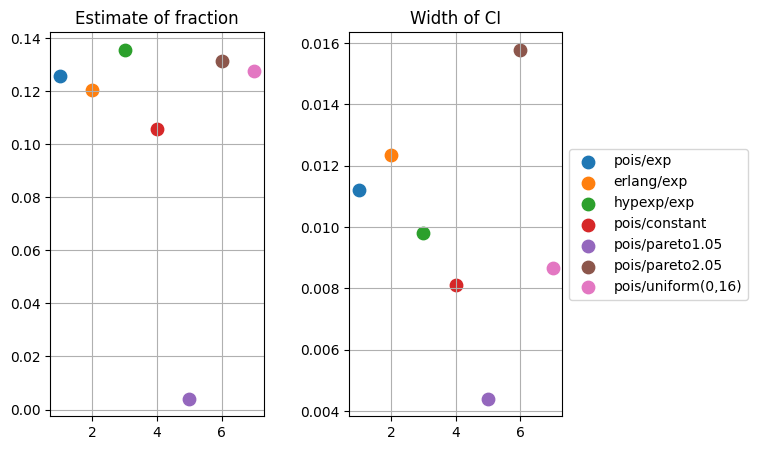

In [79]:
estimates = [thetaSTANDARD,thetaERLANG,thetaHYPEREXP,thetaCONSTANT,thetaPARETO1,thetaPARETO2,thetaUNIFORM]
widths = [cwidthSTANDARD,cwidthERLANG,cwidthHYPEREXP,cwidthCONSTANT,cwidthPARETO1,cwidthPARETO2,cwidthUNIFORM]
x = np.arange(1,len(estimates)+1,1)
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
legends = ["pois/exp","erlang/exp","hypexp/exp","pois/constant","pois/pareto1.05","pois/pareto2.05","pois/uniform(0,16)"]
fig, ax = plt.subplots(1,2)
ax[0].grid(True)
ax[1].grid(True)

for i in range(len(x)):
    ax[0].scatter(x[i],estimates[i],s=80,color=colors[i])
    ax[1].scatter(x[i],widths[i],s=80,color=colors[i],label=legends[i])

ax[0].set_title("Estimate of fraction")
ax[1].set_title("Width of CI")
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
fig.legend(loc="center right",bbox_to_anchor=(1.2,0.5))


Let's investigate the distributions as well

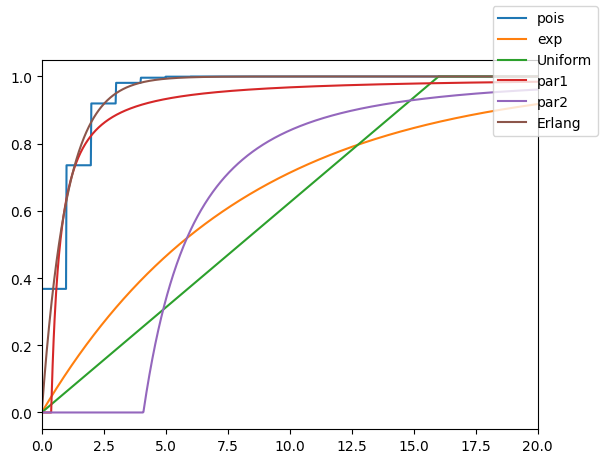

In [110]:
x = np.linspace(0, 100, 5000)
POIS = st.poisson.cdf(k=x,mu=1)
EXP = st.expon.cdf(x,scale=8)
C = [8 for i in range(len(x))]
PARETO1 =  st.pareto.cdf(x,b=1.05,scale=8*(1.05-1)/1.05)            
k = 2.05
PARETO2 = st.pareto.cdf(x,b=k,scale=8*(k-1)/k)
UNIFORM = st.uniform.cdf(x,loc=0,scale=16)  
ERLANG = st.gamma.cdf(x,a=1,scale=1)

fig, ax = plt.subplots(1,1)
ax.plot(x,POIS,label="pois")
ax.plot(x,EXP,label="exp")
#ax.plot(x,C)
ax.plot(x,UNIFORM,label="Uniform")
ax.plot(x,PARETO1,label="par1")
ax.plot(x,PARETO2,label="par2")
ax.plot(x,ERLANG,label="Erlang")
ax.set_xlim((0,20))
fig.legend()
#ax.plot(x,UNIFORM)

First off, the estimates for part (1) and part (2) are quite similar (exponential service-times). The same goes roughly for the confidence-intervals. We notice that as soon as we change the service-times, both the estimates and the confidence intervals vary highly in between experiments. 

We notice that we expect the service-times to vary more highly for the second pareto-distribution, and the expectancy is higher. Thus, a higher fraction and CI is expected for pareto k=2.05 than k=1.05, which is indeed what we observe.

When comparing pois/exp with pois/constant, we expect the same; we expect a higher variance for the non-constant arrival-times, which is indeed what we measure from the CI. 

We notice that the erlang and poisson-cdf are quite equivalent (poisson is just discrete). Therefore we get similar results for these two.

In addition, the uniform used more quickly stabilizes to constant variance than the pareto-distributions, and therefore we expect a lower variance which we also measure. 

The pois/constant distribution of course yields a higher estimate than par1 as expectancy of waiting times for par1 are lower than the used constant (8). Intuitively, I would expect the variance to be lower than for par1, which is not represented in the CI. 

In general, it may be sensible to use $E[X]$ and $Var[X]$ for the different distributions for this comparison